In [1]:
import sys
sys.path = ["/home/jmetzen/Repositories/scikit-learn", 
            "/home/jmetzen/Repositories/team/src/bayesian_optimization"] + sys.path
import cPickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#import seaborn as sns
%matplotlib inline

plt.rcParams.update({'axes.labelsize': 11,
                     'axes.titlesize': 12,
                     'text.fontsize': 11,
                     'xtick.labelsize': 8,
                     'ytick.labelsize': 8,
                     'legend.fontsize': 7,
                     'legend.fancybox': True,
                     'font.family': 'serif'})

c = ["r", "g", "b", 'k', 'm', 'c']
ms = ["o", "d", "v", "^", "s", "p"]

from joblib import Parallel, delayed

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic

from bayesian_optimization import (BayesianOptimizer, GaussianProcessModel, 
                                   MinimalRegretSearch, EntropySearch, UpperConfidenceBound,
                                   ExpectedImprovement, ProbabilityOfImprovement,
                                   GPUpperConfidenceBound)
from bayesian_optimization.utils.optimization import global_optimization

/home/jmetzen/.anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/jmetzen/.anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [77]:
#kernel = RationalQuadratic(length_scale=0.1, length_scale_bounds="fixed", alpha=0.1, alpha_bounds="fixed")
kernel = RBF(length_scale=0.1, length_scale_bounds="fixed")

n_train_points = 250
boundaries = np.array([[0.0, 1.0], [0.0, 1.0]])

n_runs = 80
n_trials = 100
settings = ["mrs", "es", "mrs_point", "ei", "gp_ucb", "pi"]

In [78]:
y_regret = np.empty((len(settings), n_runs, n_trials / 5))
X_dist = np.empty((len(settings), n_runs, n_trials / 5))
X_query = np.empty((len(settings), n_runs, n_trials, 2))
#path = "/home/jmetzen/Repositories/BesMan/SVN/Documentation/Publications/PeerReviewed/drafts/2016_ICML/results/log_200/"
path = "/home/jmetzen/Temp/log/"
for filename in __import__("os").listdir(path):
    res = cPickle.load(open(path + filename))
    setting, run, y_regret_, X_dist_, X_query_ = res
    if run >= n_runs: continue
    i = settings.index(setting)
    y_regret[i, run] = y_regret_
    X_dist[i, run] = X_dist_
    X_query[i, run] = X_query_

## Plotting

In [79]:
setting_names = {
    "mrs": "MRS",
    "es": "ES",
    "mrs_point": r"MRS$^{point}$",
    "ei": "EI",
    "gp_ucb": "GP-UCB",
    "pi": "PI"
}

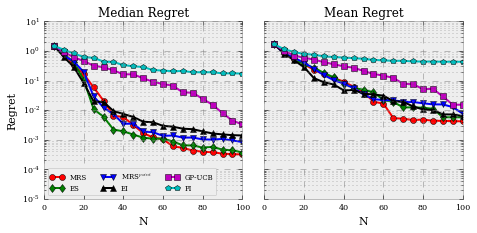

In [80]:
fig_width = 487.8225 / 72.27  # Get fig_width_pt from LaTeX using \showthe\columnwidth
fig_height = fig_width * 0.5  # height in inches
plt.figure(0, dpi=400, figsize=(fig_width, fig_height))

ax = plt.subplot(1,2,1)
for i, setting in enumerate(settings):
    ax.plot(np.arange(5, n_trials+1, 5), np.median(y_regret[i], 0), 
            c=c[i], marker=ms[i], label=setting_names[setting])
ax.set_ylim(1e-5, 1e1)
#ax.tick_params(axis='y', which='minor')
#ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_yscale("log")
ax.set_xlabel("N")
ax.set_ylabel("Regret")
ax.grid(b=True, which='major', color='gray', linestyle='--')
ax.grid(b=True, which='minor', color='gray', linestyle=':')
ax.legend(loc="best", ncol=3, )
ax.set_title("Median Regret")

ax = plt.subplot(1,2,2)
for i, setting in enumerate(settings):
    ax.plot(np.arange(5, n_trials+1, 5), np.mean(y_regret[i], 0), 
            c=c[i], marker=ms[i], label=setting_names[setting])
ax.set_ylim(1e-5, 1e1)
ax.set_yscale("log")
ax.set_xlabel("N")
ax.set_yticklabels([])
ax.grid(b=True, which='major', color='gray', linestyle='--')
ax.grid(b=True, which='minor', color='gray', linestyle=':')
#ax.legend(loc="upper center", ncol=3)
ax.set_title("Mean Regret")

#axins = inset_axes(ax, width="40%", height="40%", loc=1)  # zoom = 6
#axins.scatter(y_regret[0, :, -1], y_regret[1, :, -1], c='r')
#axins.set_xscale("log")
#axins.set_yscale("log")
#axins.set_xlim(1e-10, 1e0)
#axins.set_ylim(1e-10, 1e0)
#axins.set_xticks(np.logspace(-10, 0, 6))
#axins.set_yticks(np.logspace(-10, 0, 6))
#axins.set_axis_bgcolor("white")
#axins.plot([1e-10, 1e0], [1e-10, 1e0])
#axins.set_xlabel("MRS Regret")
#axins.set_ylabel("ES Regret")

plt.tight_layout()

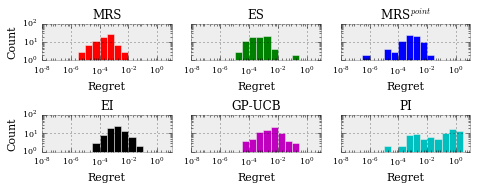

In [81]:
fig_width = 487.8225 / 72.27  # Get fig_width_pt from LaTeX using \showthe\columnwidth
fig_height = fig_width * 0.4  # height in inches
plt.figure(0, dpi=400, figsize=(fig_width, fig_height))

for i, setting in enumerate(settings):
    ax = plt.subplot(2, 3, i+1)
    ax.hist(np.maximum(y_regret[i, : , -1], 1e-12), #normed=True,
            bins=np.logspace(-8, 1, 19), color=c[i])
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(setting_names[setting])
    ax.set_xticks([1e-8, 1e-6, 1e-4, 1e-2, 1e0])
    if i % 3 != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Count")
    ax.set_xlabel("Regret")
plt.tight_layout()

In [ ]:
from scipy.stats import wilcoxon
print wilcoxon(y_regret[0, : , -5], y_regret[1, : , -5])

In [ ]:
?wilcoxon